# Problem Set 1: Wearables

The problems in this problem set pertain to the following paper:

Li, X., Dunn, J., Salins, D., Zhou, G., Zhou, W., Rose, S. M. S. F., ... & Sonecha, R. (2017). [Digital health: tracking physiomes and activity using wearable biosensors reveals useful health-related information.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2001402) PLoS biology, 15(1), e2001402.


Please read this paper before starting this problem set, so you have context.

Interestingly, all of this data has been made publicly available. We will be working with a small subset in order to gain experience working with wearable data. Our goal will be to detect evidence of jetlag in Participant 1 as they travel. [Jetlag](https://en.wikipedia.org/wiki/Jet_lag) is a condition resulting from disrupted circadian rhythm while traveling.

## Part 1: About Time!

Wearable data typically takes the form of a time series. One major factor to consider is how to represent time. We can use a human readable format (ex: **Thursday, March 1, 2018 1:42:59 PM** or **3/1/18 13:42:59**) or a timestamp (ex: **1519940579**). We also need to think about timezone - as Participant 1 travels, their timezone changes, which in turn changes their local time. We often represent timezone by storing a GMT offset. Sometimes it makes sense to work with local time and other times we’ll want to work with GMT. [This](https://www.epochconverter.com) is a useful resource that explains and converts between different representations of time. If you scroll down, it also gives code examples in a variety of languages (including Python and R).

In [1]:
import pandas as pd

### 1.1

**What is GMT? For the time ​Thursday, March 1, 2018 1:42:59 PM GMT-08:00​, what does GMT-08:00 mean?**

Greenwich Mean Time (GMT) is the yearly average (mean) of the time each day when the Sun crosses the Prime Meridian at the Royal Observatory Greenwich. This time is also referred as UTC (coordinated universal time) as a time standard as basis for time zones worldwide. The GMT-8:00 indicates the time zone Pacific standard time (PST), which means minus 8 hours offset from GMT when not in daylight saving time. 

### 1.2

**What is a timestamp, and what does it represent? What date and time is `1519940579`, in human readable format?**

A timestamp is a sequence of characters or encoded information identifying when an event occured, usually containing both date and time of the day. A timestamp can have any epoch and can be relative to any arbitrary time. 

Unix time is a date and time representation widely used in computing, and it measures time by number of seconds elapsed since 00:00:00 UTC on January 1, 1970 (unix epoch). The date time of 1519940579 in human readable format is Thursday, March 1, 2018 9:42:59 PM GMT (or  Thursday, March 1, 2018 1:42:59 PM GMT-08:00). 

In [43]:
import time
print(time.strftime("%a, %d %b %Y %H:%M:%S GMT", time.gmtime(1519940579)))
print(time.strftime("%a, %d %b %Y %H:%M:%S GMT-08:00", time.localtime(1519940579)))

Thu, 01 Mar 2018 21:42:59 GMT
Thu, 01 Mar 2018 13:42:59 GMT-08:00


## Part 2: Time-Consuming Analysis

**Participant 1’s sleep data was collected using a Basis Watch and is stored in `sleep_to_03-31-16.csv`. Notice that this file includes local start and end times (`local_start_time`, `local_end_time`) as well as timestamps (`start_timestamp`, `end_timestamp`) and GMT start and end times (`start_time_iso`, `end_time_iso`).**

### 2.1

**Let’s figure out how many hours Participant 1 sleeps per day. Make a histogram of the total number of hours slept each day. Use GMT start time to determine what day sleep occurs on and actual_minutes to determine sleep duration. Include a line on the plot showing average sleep per day.**

In [3]:
df_sleep = pd.read_csv('./sleep_to_03-31-16.csv')

In [7]:
df_sleep['start_time_iso'] = pd.to_datetime(df_sleep['start_time_iso'])
df_sleep['start_time_iso_date'] = df_sleep['start_time_iso'].dt.date

In [18]:
df_actual_min_per_date = df_sleep.groupby(by='start_time_iso_date')['actual_minutes'].sum().reset_index()

In [19]:
df_actual_min_per_date

,start_time_iso_date,actual_minutes
0,2015-06-01,60
1,2015-06-02,508
2,2015-06-03,344
3,2015-06-06,271
4,2015-06-07,514
...,...,...
296,2016-03-28,338
297,2016-03-29,279
298,2016-03-30,331
299,2016-03-31,638


Text(0.5, 1.0, 'Daily Sleep Duration (hour)')

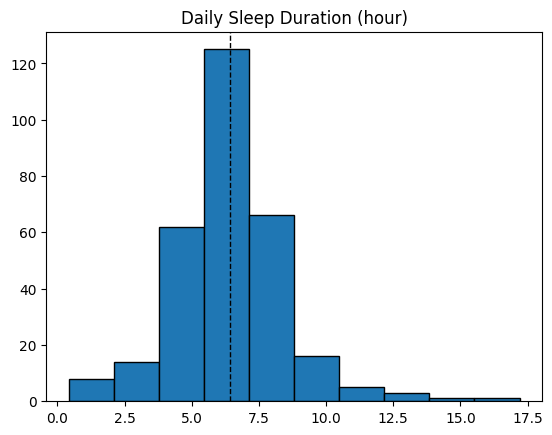

In [430]:
import matplotlib.pyplot as plt
plt.hist(df_actual_min_per_date['actual_minutes']/60, edgecolor='k')
plt.axvline(df_actual_min_per_date['actual_minutes'].mean()/60, color='k', linestyle='dashed', linewidth=1)
plt.title("Daily Sleep Duration (hour)")


### 2.2

**Report basic features of the distribution of daily sleep for Participant 1: mean, median, standard deviation, minimum, and maximum. Comment on whether these values seem reasonable. Do the data look reliable, or do you think the observations are noisy or error-prone?**

In [431]:
print('Daily sleep duration Mean:', df_actual_min_per_date['actual_minutes'].mean()/60)
print('Daily sleep duration Median:', df_actual_min_per_date['actual_minutes'].median()/60)
print('Daily sleep duration Standard Deviation:', df_actual_min_per_date['actual_minutes'].std()/60)
print('Daily sleep duration Min:', df_actual_min_per_date['actual_minutes'].min()/60)
print('Daily sleep duration Max:', df_actual_min_per_date['actual_minutes'].max()/60)

Daily sleep duration Mean: 6.440088593576966
Daily sleep duration Median: 6.466666666666667
Daily sleep duration Standard Deviation: 2.082853845154087
Daily sleep duration Min: 0.4166666666666667
Daily sleep duration Max: 17.2


The mean, median and standard deviation data looks reasonable, where mean and median correspond to around 6.4 hours of sleep per day and standard deviation being around 2 hours. The 4 to 8 hours of sleep is within the normal sleep schedule time range. 

The min sleep time of 25 minutes and max sleep time of 17.2 hours are not so reasonable, but these observations might be influenced by various reasons such as fatigue after flight or resting during long distance flight. The noisy observations of short sleep time might be recognized from short nap or because of device noise in recordings. These min and max time can be recognized as outliers in the distribution. 

Overall looking at the histogram, since the data display roughly normal distribution with a reasonable mean/standard deviation, the observations mostly make sense and are not extremely error-prone. 

## Part 3: Time Flies

Participant 1’s travel information is in `activities.csv`. This file contains information on a variety of activities, including (somewhat bizarrely) `table_tennis`. Note that start and end times are given in local time but a GMT offset is included.

We would like to extract a list of flights taken by Participant 1. However, as with a lot of wearable data, our labels are imperfect. Some flights are labeled `airplane` in the `Activity` column and others are labeled `transport`. However, `transport` is also used for car rides, train rides, etc. We will define a flight as an activity that is either (labeled `airplane`) OR (labeled `transport` AND has an average speed over 100 miles/hour). You can calculate speed from `Duration` (given in seconds) and `Distance` (given in miles).

### 3.1

**How many flights did Participant 1 take? Plot a histogram of the duration (in hours) of these flights. Is there anything unexpected about the distribution of durations? Give an explanation for what could give rise to these observations, and propose a way to post-process them (for purposes of this assignment, we'll be leaving these data as-is).**

In [456]:
df_activities = pd.read_csv('./activities.csv')

In [453]:
df_activities['Start'] = pd.to_datetime(df_activities['Start'], utc=True)
df_activities['End'] = pd.to_datetime(df_activities['End'], utc=True)
df_activities['Start_date'] = df_activities['Start'].dt.date

In [125]:
df_activities['speed'] = df_activities['Distance']/(df_activities['Duration']/3600)

In [126]:
df_activities_plane = df_activities[(df_activities['Activity']=='airplane') | 
                                    ((df_activities['Activity']=='transport') & (df_activities['speed']>100)) ]
df_activities_plane_perday = df_activities_plane.groupby(by='Start_date')['Duration'].sum().reset_index()

Text(0.5, 1.0, 'Flight Duration (Hours) - Individual flight record instance')

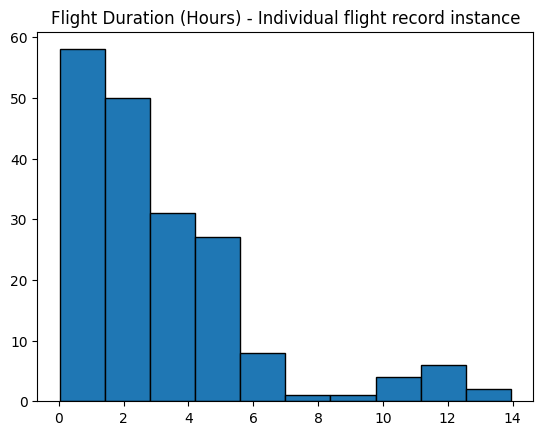

In [433]:
plt.hist(df_activities_plane['Duration']/3600, edgecolor='k')
plt.title("Flight Duration (Hours) - Individual flight record instance")

Text(0.5, 1.0, 'Flight Duration (Hours) - Sum from flight records on the same day')

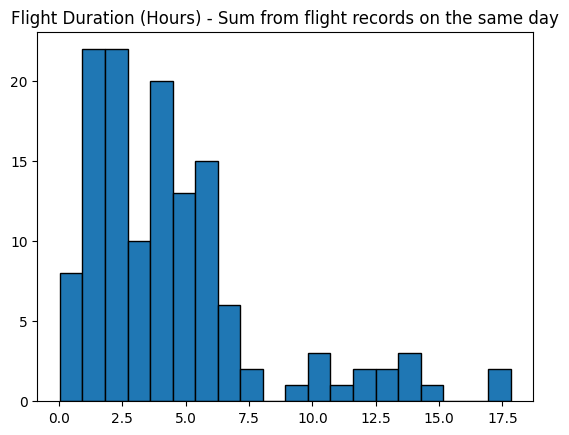

In [129]:
plt.hist(df_activities_plane_perday['Duration']/3600, bins=20, edgecolor='k')
plt.title("Flight Duration (Hours) - Sum from flight records on the same day")

In [130]:
df_activities_plane[['Start', 'End']][:10], df_activities_plane.Start_date.unique()[:10]

(                        Start                       End
 27  2014-03-23 12:54:16+00:00 2014-03-23 12:58:21+00:00
 28  2014-03-23 12:58:22+00:00 2014-03-23 14:47:24+00:00
 32  2014-03-23 15:38:54+00:00 2014-03-23 19:44:15+00:00
 79  2014-03-25 03:05:43+00:00 2014-03-25 07:00:00+00:00
 80  2014-03-25 07:00:00+00:00 2014-03-25 10:55:56+00:00
 136 2014-03-28 08:31:28+00:00 2014-03-28 09:51:56+00:00
 142 2014-03-28 11:36:49+00:00 2014-03-28 22:50:15+00:00
 223 2014-04-01 23:29:19+00:00 2014-04-02 03:30:10+00:00
 270 2014-04-03 20:41:19+00:00 2014-04-04 01:08:08+00:00
 318 2014-04-06 20:15:54+00:00 2014-04-06 22:34:14+00:00,
 array([datetime.date(2014, 3, 23), datetime.date(2014, 3, 25),
        datetime.date(2014, 3, 28), datetime.date(2014, 4, 1),
        datetime.date(2014, 4, 3), datetime.date(2014, 4, 6),
        datetime.date(2014, 4, 9), datetime.date(2014, 4, 14),
        datetime.date(2014, 4, 16), datetime.date(2014, 4, 17)],
       dtype=object))

In [131]:
df_activities_plane.shape[0], df_activities_plane_perday.shape[0]

(188, 133)

If we consider each record of flight separately, there is a total of **188** flight records from participant 1 that meets the criteria (record = 'airplane' or has record = 'transport' and speed > 100mph). If we consider each flight instance occuring on the same day to be 1 flight instance (as some records' start and end timestamps are connected, which indicate that they are from the same flight), there is **133 unique dates** in the flight records. 

From the distribution of durations of individual flight record, we can see most records have time under 5 hours and there are a few long duration flight of 10-14 hours. The large number of records having duration under 1 hour is somewhat unexpected, since it may be rare to take short flights under 1 hour frequently and there are multiple flight records occurring on the same day without any gap in start and end (ex. 2014-03-23). Since it is not common to take multiple different short flights without any layover time, it can be deduced that those records are from the same flight and the device may recognized a single flight into different records. 

One way to post-process them is to calculate the time gap in flight records, and for records having short gap time (ex. under 2 hours), they should be combined and regarded as the same flight. Another short cut is to simply combine flight records on the same day (as experimented above), although this may combine non-direct flights that are separate but occurred on the some day. 


### 3.2

**Now we know when Participant 1 traveled and when they slept. Let’s put them together. We want to compare Participant 1’s sleep after traveling to their usual sleep. To do this, we’ll want to use GMT for both our flight and sleep times. Using the flight dates from question 3.1, generate a set of dates within 3 days of flight. That is, if they traveled on 3/23/14, then you should include 3/23/14, 3/24/14, and 3/25/14 as "after-flight" dates**. 

**Re-make the histogram of sleep duration from (2.1), stratifying by whether the date is an "after-flight" day. Then use a t-test to compare sleep "after-flight" to sleep not "after-flight" and report your results.**

In [133]:
import datetime
after_flight_dates = []
for date in df_activities_plane_perday['Start_date'].tolist(): 
    after_flight_dates.append(date)
    after_flight_dates.append(date+datetime.timedelta(days=1))
    after_flight_dates.append(date+datetime.timedelta(days=2))

In [138]:
import numpy as np
len(after_flight_dates)

after_flight_dates = np.array(after_flight_dates)
after_flight_dates = np.unique(after_flight_dates)

In [450]:
after_flight_dates[:10], after_flight_dates.shape 

(array([datetime.date(2014, 3, 23), datetime.date(2014, 3, 24),
        datetime.date(2014, 3, 25), datetime.date(2014, 3, 26),
        datetime.date(2014, 3, 27), datetime.date(2014, 3, 28),
        datetime.date(2014, 3, 29), datetime.date(2014, 3, 30),
        datetime.date(2014, 4, 1), datetime.date(2014, 4, 2)], dtype=object),
 (306,))

In [144]:
df_actual_min_per_date['after_flight'] = df_actual_min_per_date['start_time_iso_date'].isin(after_flight_dates)

In [441]:
df_actual_min_per_date

,start_time_iso_date,actual_minutes,after_flight
0,2015-06-01,60,True
1,2015-06-02,508,True
2,2015-06-03,344,True
3,2015-06-06,271,True
4,2015-06-07,514,False
...,...,...,...
296,2016-03-28,338,False
297,2016-03-29,279,False
298,2016-03-30,331,True
299,2016-03-31,638,True


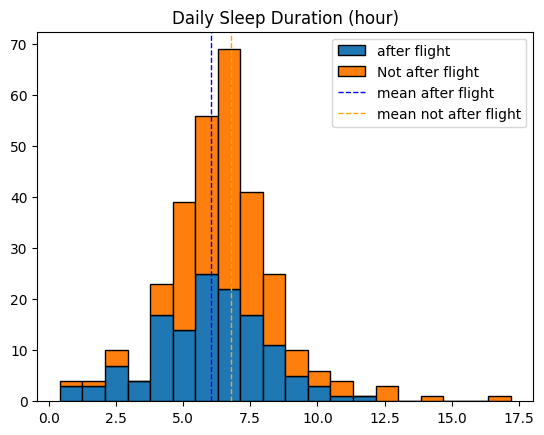

In [446]:
plt.hist([df_actual_min_per_date[df_actual_min_per_date['after_flight']==True]['actual_minutes']/60, 
          df_actual_min_per_date[df_actual_min_per_date['after_flight']==False]['actual_minutes']/60], bins=20, edgecolor='k', histtype='bar',  stacked=True, label=['after flight', 'Not after flight'])
plt.axvline(df_actual_min_per_date[df_actual_min_per_date['after_flight']==True]['actual_minutes'].mean()/60, color='blue', linestyle='dashed', linewidth=1, label='mean after flight')
plt.axvline(df_actual_min_per_date[df_actual_min_per_date['after_flight']==False]['actual_minutes'].mean()/60, color='orange', linestyle='dashed', linewidth=1, label='mean not after flight')
plt.title("Daily Sleep Duration (hour)")
plt.legend() 

In [158]:
print('Mean sleep duration (minutes) after flight:', df_actual_min_per_date[df_actual_min_per_date['after_flight']==True]['actual_minutes'].mean())
print('Mean sleep duration (minutes) not after flight:', df_actual_min_per_date[df_actual_min_per_date['after_flight']==False]['actual_minutes'].mean())

Mean sleep duration (minutes) after flight: 361.42105263157896
Mean sleep duration (minutes) not after flight: 406.1845238095238


In [447]:
df_actual_min_per_date[df_actual_min_per_date['after_flight']==True]['actual_minutes']/60

0       1.000000
1       8.466667
2       5.733333
3       4.516667
8       5.683333
         ...    
289     5.650000
290     4.566667
298     5.516667
299    10.633333
300     4.433333
Name: actual_minutes, Length: 133, dtype: float64

In [442]:
from scipy.stats import ttest_ind
ttest_ind(df_actual_min_per_date[df_actual_min_per_date['after_flight']==True]['actual_minutes']/60, 
          df_actual_min_per_date[df_actual_min_per_date['after_flight']==False]['actual_minutes']/60)

TtestResult(statistic=-3.1310602884089387, pvalue=0.0019140632656736178, df=299.0)

The p-value is 0.001914 from the t-test. Setting alpha=0.05, we see the p-value is less than 0.05, indicating statistical significance. This indicates that the difference in mean for the 2 distributions (sleep duration after flight and not after flight) are not due to random chance, as the null hypothesis (2 distribution means are equal) is rejected. 

### 3.3

**What can we conclude about airplane flights and sleep for Participant 1? Is there an association between the two, and if so, how large is the effect?**

The t-test is used to determine if there is statistically significant difference between means of 2 groups. From the result above, we can conclude that sleep duration increases for days after flight for Participant 1 (with mean difference of 45 min) and that this difference between sleep duration data after flight and sleep duration data not after flight is statistically significant. However, we have not assessed whether flight and sleep duration is directly associated or how large the effect is, i.e, the association between flight duration and sleep duration in days after. 

## Part 4: Every Minute Counts

### 4.1

**For this part, delve into analyzing biometric data collected via the Basis watch, stored in the `bodymetrics_to_03-31-16.csv` file. This dataset contains physiological parameters like heart rate and skin temperature, possibly recorded as frequently as every minute. Your task is to use this rich data to create a figure/figures that reveal an insightful pattern (or lack of an expected pattern) about the recorded metrics.**

**Consider exploring how these metrics fluctuate under different conditions. For instance, you might analyze the impact of travel on heart rate, drawing inspiration from Part 3 using heart rate instead of sleep. Alternatively, you could examine the trend of heart rate throughout the day, observing how it varies with different activities or times.**

**You should include figure/figures that you create along with a description of your interpretation of those figures. Also include any brief data quality checks or cleaning that you did to the new dataset.**

**You are encouraged to refer to the paper mentioned at the beginning of the notebook for ideas. While specific suggestions have been provided, you are also welcome to employ creative approaches in your analysis.  Enjoy exploring the data!**

In [396]:
df_bodymetrics = pd.read_csv('./bodymetrics_to_03-31-16.csv') 

In [426]:
df_bodymetrics['date'] = pd.to_datetime(df_bodymetrics['date'], utc=True)
df_bodymetrics['date_day'] = df_bodymetrics['date'].dt.date
df_bodymetrics = df_bodymetrics.sort_values('date_day')

In [399]:
df_bodymetrics['date_day'].min(), df_bodymetrics['date_day'].max()

(datetime.date(2015, 5, 20), datetime.date(2016, 3, 31))

## Explore impact of cardio exercise to physiological metrics 

In the following analysis, I aim to analyze the impact of cardio exercise to physiological metrics. Specifically, I wish to see how medium/high intensity cardio exercises such as running impact the physiological parameters. It has been studied and suggested that having regular/increased cardio exercise can lower resting heart rate (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6306777/), specifically, the effect occurs after only a few months - on average, three months with three training sessions per week. It would be interesting to see if this trend shows in the biometric data for this participant. 

First, we examine the activity data for the period when the biometric data was collected. The monthly averaged duration for each activity was plotted, and used to identify the common cardio exercise this participant performed. Then, to simplify the analysis, the averaged duration for each activity performed by the participant per month is calculated to identify the months where he/she exercised for longer-than-overall-average duration (high exercise months). Then, we classify the biometric data into 'in_target_exercise' or not, and compute the averages for the 'in-exercise' and resting data for each day. Some trends on biometrics differences between in-exericse and not-in-exercise periods are identified from this analysis. Finally, a statistical significance test is used on the resting heart rate distributions of high exercise months and low exercise months. 

Interpretations on data quality and observations are annotated below. 

First, we get activity data within the frame of period when the biometric data are available. 

In [207]:
import seaborn as sns
df_activities_subset = df_activities[(df_activities['Start_date']>=df_bodymetrics['date_day'].min()) & (df_activities['Start_date']<=df_bodymetrics['date_day'].max())]

In [365]:
df_activities_subset['Duration_min'] = df_activities_subset['Duration']/60

To help with easier analysis, we identify the year-month for each data point. 

In [343]:
import warnings
warnings.filterwarnings('ignore')
df_activities_subset['Start_year_month'] = df_activities_subset['Start'].dt.strftime('%Y-%m');

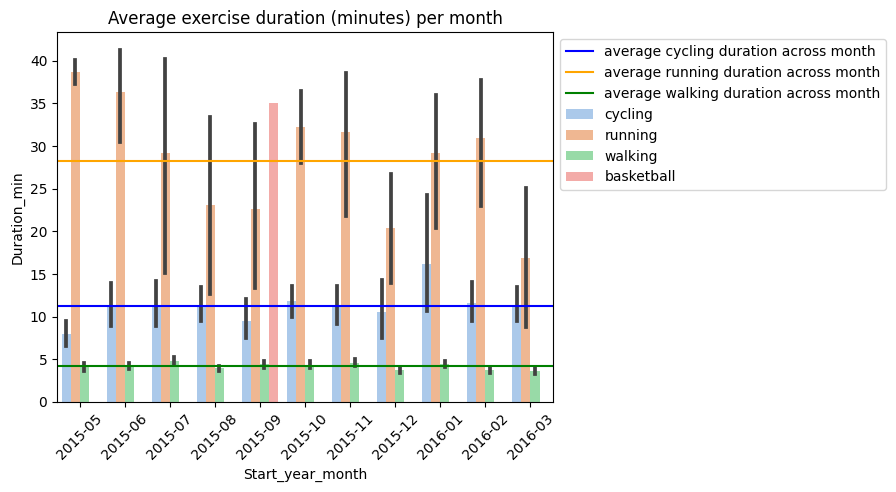

In [368]:
plot = sns.barplot(data=df_activities_subset[df_activities_subset['Activity'].isin(['running', 'walking', 'cycling', 'basketball'])].sort_values(
                                                                                                    ['Start_year_month','Activity']),
             x="Start_year_month", y='Duration_min',estimator='mean',
             palette="pastel", hue="Activity")
plt.xticks(rotation=45)
## show mean of averaged per month duration 
mean_cycling = df_activities_subset[df_activities_subset['Activity']=='cycling'].groupby('Start_year_month').agg(
                                                                        {'Duration_min':'mean'}).reset_index()['Duration_min'].mean()
mean_running = df_activities_subset[df_activities_subset['Activity']=='running'].groupby('Start_year_month').agg(
                                                                        {'Duration_min':'mean'}).reset_index()['Duration_min'].mean()
mean_walking = df_activities_subset[df_activities_subset['Activity']=='walking'].groupby('Start_year_month').agg(
                                                                        {'Duration_min':'mean'}).reset_index()['Duration_min'].mean()
plt.axhline(y=mean_cycling, label='average cycling duration across month', c='blue') 
plt.axhline(y=mean_running, label='average running duration across month', c='orange') 
plt.axhline(y=mean_walking, label='average walking duration across month', c='green') 
plt.title("Average exercise duration (minutes) per month")
plt.legend()
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

In [367]:
df_activities_subset[df_activities_subset['Activity']=='basketball']

,Date,Activity,Group,Start,End,Duration,Distance,Steps,Calories,Start_date,speed,Start_year_month,Duration_min
12620,9/17/15,basketball,NaN,2015-09-17 05:30:44+00:00,2015-09-17 06:05:44+00:00,2100,0.0,0,199,2015-09-17,0.0,2015-09,35.0


From the above, we can see that some activities such as running, cycling and basketball have larger percentages in months such as May, June, September, October 2015 and January, Feburary 2016. 

However, it seems that walking/cycling are not 'exercises' the participant did but rather possibly occurs during commuting, since the durations are low for both types of activity (not exceeding 20min for monthly average). Moreover, we can see that there was only 1 datapoint for basketball from September 2015, suggesting that it is not a regular exercise for this participant. 

Hence in this analysis, we will use running activity data to calculate 'high exercise months' and to identify in-exercise biometric data. 

In [369]:
## months where the monthly activity duration average exceeds overall average in the data: 
df_activity_run_month_avg = df_activities_subset[df_activities_subset['Activity']=='running'].groupby('Start_year_month').agg({'Duration_min':'mean'}).reset_index()

In [374]:
df_activity_run_month_avg[:3]

,Start_year_month,Duration_min
0,2015-05,38.708333
1,2015-06,36.316667
2,2015-07,29.230000


In [375]:
print('mean running duration per month: ', mean_running)

mean running duration per month:  28.285290774040774


In [380]:
high_exercise_months = df_activity_run_month_avg[df_activity_run_month_avg['Duration_min']>mean_running]['Start_year_month'].tolist()
high_exercise_months

['2015-05', '2015-06', '2015-07', '2015-10', '2015-11', '2016-01', '2016-02']

Now, we can match the running activity durations to the biometric data. We will indicate whether a biometric datapoint has date falling within a running activity duration in the 'in_target_exercise' column. 

In [381]:
df_activities_exercise = df_activities_subset[df_activities_subset['Activity']=='running']

In [386]:
df_activities_exercise[:3]

,Date,Activity,Group,Start,End,Duration,Distance,Steps,Calories,Start_date,speed,Start_year_month,Duration_min
9898,5/23/15,running,running,2015-05-23 23:48:12+00:00,2015-05-24 00:25:29+00:00,2237,3.759,6114,379,2015-05-23,6.049352,2015-05,37.283333
10101,5/30/15,running,running,2015-05-31 00:33:06+00:00,2015-05-31 01:13:14+00:00,2408,4.107,6503,413,2015-05-31,6.140033,2015-05,40.133333
10274,6/6/15,running,running,2015-06-06 23:14:51+00:00,2015-06-06 23:50:35+00:00,2144,3.714,5760,373,2015-06-06,6.236194,2015-06,35.733333


In [383]:
def in_exercise(date):
    for start_timestamp, end_timestamp in zip(df_activities_exercise.Start, df_activities_exercise.End): 
        if date>start_timestamp and date<end_timestamp: 
            return True 
    return False

In [400]:
df_bodymetrics['in_target_exercise'] = df_bodymetrics['date'].apply(lambda x: in_exercise(x))

In [401]:
df_bodymetrics['in_target_exercise'].value_counts()

in_target_exercise
False    449414
True       2160
Name: count, dtype: int64

In [402]:
df_bodymetrics[df_bodymetrics['heart-rate'].isna()]['in_target_exercise'].sum()

9

We can see that there were some missing heart rate (and the rest of biometrics) data, but because most data points are not in exercise (only 9 datapoints have in exercise as True) and that there are still a large amount of not in exercise data, we will directly exclude them to simplify the analysis.

In [403]:
df_bodymetrics.shape

(451574, 8)

In [404]:
df_bodymetrics.dropna(inplace=True)

In [405]:
df_bodymetrics.shape

(425841, 8)

Now, we can compute the per day averages for each biometric for in-exercise and not in exercise groups. 

In [415]:
df_bodymetrics['month'] = df_bodymetrics['date'].dt.strftime('%Y-%m');

In [417]:
df_bodymetrics_perday = df_bodymetrics.groupby(['date_day', 'in_target_exercise']).agg(
    {'month': 'first', 'heart-rate': 'mean', 'steps': 'mean', 'skin-temp': 'mean', 'calories': 'mean'}).reset_index()

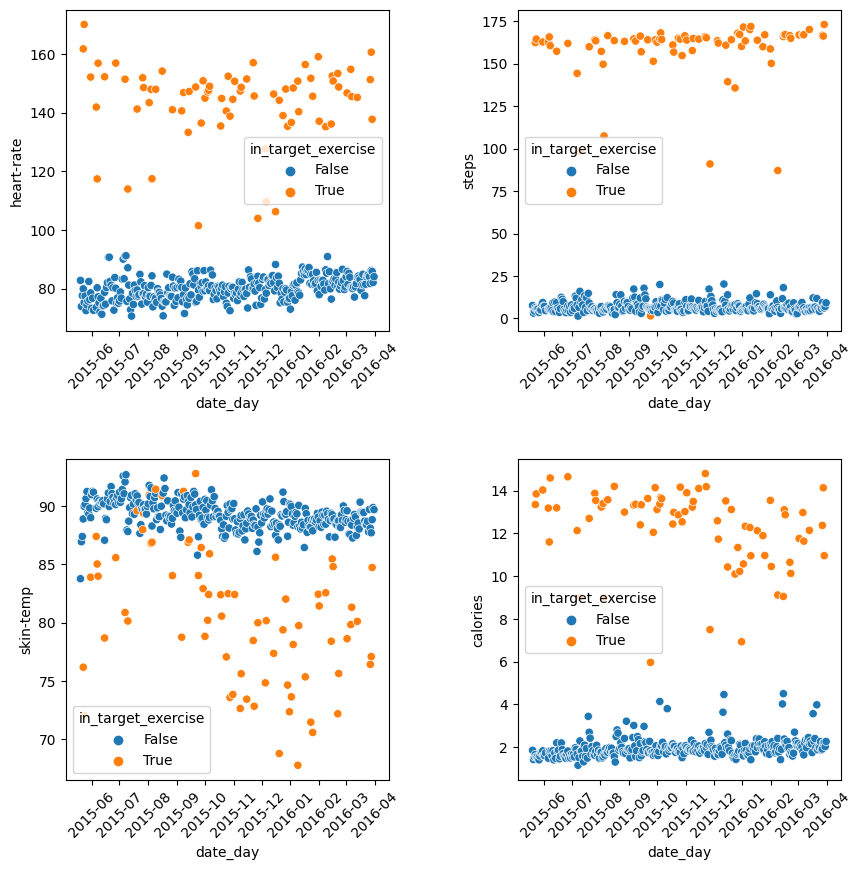

In [462]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(data=df_bodymetrics_perday, x='date_day', y='heart-rate', hue='in_target_exercise')
plt.xticks(rotation=45);
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(data=df_bodymetrics_perday, x='date_day', y='steps', hue='in_target_exercise')
plt.xticks(rotation=45);
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(data=df_bodymetrics_perday, x='date_day', y='skin-temp', hue='in_target_exercise')
plt.xticks(rotation=45);
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(data=df_bodymetrics_perday, x='date_day', y='calories', hue='in_target_exercise')
plt.xticks(rotation=45);
plt.show()

From the above plot, we can see that during exercise, the participant has a higher heart rate, higher steps, higher calories burnt per second and lower skin temperature (sweating lowering heat), all expected from the impacts of running. Generally looking at the trend of resting data points (in_target_exercise = False), there is no suggestions for a lower resting heart rate due to exercises. However, it does seem like a slight upward trend is present for higher calories burnt in resting periods over the observing period. Two statistical tests are conducted to see if the differences are statistically significant for high exercise and low exercise months.  

In [420]:
df_bodymetrics_perday[:3]

,date_day,in_target_exercise,month,heart-rate,steps,skin-temp,calories
0,2015-05-20,False,2015-05,82.840000,7.613333,83.774000,1.854667
1,2015-05-21,False,2015-05,73.934010,3.155668,86.942640,1.423858
2,2015-05-22,False,2015-05,77.646755,4.340708,87.394469,1.549115


In [421]:
df_bodymetrics_perday['above_avg_months'] = df_bodymetrics_perday['month'].isin(high_exercise_months)

In [423]:
from scipy.stats import ttest_ind
## test resting heart rate between high and low exercise months 
ttest_ind(df_bodymetrics_perday[(df_bodymetrics_perday['in_target_exercise']==False) & 
                                (df_bodymetrics_perday['above_avg_months']==True)]['heart-rate'], 
          df_bodymetrics_perday[(df_bodymetrics_perday['in_target_exercise']==False) & 
                                (df_bodymetrics_perday['above_avg_months']==False)]['heart-rate'])

TtestResult(statistic=-0.22226910092208274, pvalue=0.824249364657404, df=313.0)

In [424]:
## test resting calories between high and low exercise months 
ttest_ind(df_bodymetrics_perday[(df_bodymetrics_perday['in_target_exercise']==False) & 
                                (df_bodymetrics_perday['above_avg_months']==True)]['calories'], 
          df_bodymetrics_perday[(df_bodymetrics_perday['in_target_exercise']==False) & 
                                (df_bodymetrics_perday['above_avg_months']==False)]['calories'])

TtestResult(statistic=-2.0927086170082383, pvalue=0.037180155719431306, df=313.0)

It seems that the resting heart rate indeed does not have statistical significant difference between high exercise months and low exercise months (p>0.05). However, there is a statistical significance between calories at rest in high exercise months and low exercise months (p<=0.05 at 0.037). 

Overall, it is hard to conclude whether exercise had an impact to both heart rate and calories just using these data. For example, it was not disclosed whether participant had regularly exercised prior to the start of biometric data collection. If he/she was regularly exercising, we may expect different thresholds for determining high/low exercise months and expect less impact from exercising to resting heart rate. Hence, more long term data is needed to conclude on the impact of exercising for this participant. 